In [1]:
import numpy as np
import os

def read_lammps_dump(filename):
    """Reads a LAMMPS trajectory file and extracts box dimensions and atomic positions."""
    with open(filename, "r") as f:
        lines = f.readlines()

    frames = []
    i = 0
    while i < len(lines):
        if "ITEM: TIMESTEP" in lines[i]:
            timestep = int(lines[i + 1].strip())
            i += 2
        elif "ITEM: BOX BOUNDS" in lines[i]:
            # Read box bounds
            x_bounds = list(map(float, lines[i + 1].strip().split()))
            y_bounds = list(map(float, lines[i + 2].strip().split()))
            z_bounds = list(map(float, lines[i + 3].strip().split()))
            i += 4
        elif "ITEM: ATOMS" in lines[i]:
            # Read atomic data
            atom_data = []
            headers = lines[i].strip().split()[2:]  # Extract column names
            i += 1
            while i < len(lines) and "ITEM:" not in lines[i]:
                atom_data.append(list(map(float, lines[i].strip().split())))
                i += 1

            atom_data = np.array(atom_data)
            frames.append({
                "timestep": timestep,
                "box": (x_bounds, y_bounds, z_bounds),
                "atoms": atom_data,
                "headers": headers,
            })
        else:
            i += 1

    return frames


def write_vasp_file(frame, filename, atom_type_map, updated_counts):
    """Writes a single frame to a VASP POSCAR/CONTCAR file."""
    x_bounds, y_bounds, z_bounds = frame["box"]
    atoms = frame["atoms"]
    headers = frame["headers"]

    # Extract lattice vectors from box bounds
    a = x_bounds[1] - x_bounds[0]
    b = y_bounds[1] - y_bounds[0]
    c = z_bounds[1] - z_bounds[0]
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [0.0, b, 0.0],
        [0.0, 0.0, c],
    ])

    # Extract atom types and positions
    atom_types = atoms[:, headers.index("type")].astype(int)
    positions_cartesian = atoms[:, [headers.index("x"), headers.index("y"), headers.index("z")]]

    # Convert Cartesian coordinates to fractional
    inv_lattice = np.linalg.inv(lattice_vectors)
    positions_fractional = np.dot(positions_cartesian - [x_bounds[0], y_bounds[0], z_bounds[0]], inv_lattice)

    # Map numerical atom types to chemical symbols
    chemical_symbols = [atom_type_map[t] for t in atom_types]

    # Write VASP POSCAR/CONTCAR format with updated counts
    with open(filename, "w") as f:
        f.write(f"Generated from LAMMPS dump file\n")
        f.write(f"1.0\n")
        for vec in lattice_vectors:
            f.write(f"{vec[0]:.6f} {vec[1]:.6f} {vec[2]:.6f}\n")
        f.write(" ".join(updated_counts.keys()) + "\n")  # Chemical symbols
        f.write(" ".join(map(str, updated_counts.values())) + "\n")  # Updated counts
        f.write("Direct\n")
        
        for symbol in updated_counts.keys():
            count_to_write = updated_counts[symbol]
            symbol_positions = positions_fractional[np.array(chemical_symbols) == symbol]
            
            for pos in symbol_positions[:count_to_write]:
                f.write(f"{pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")


def convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts):
    """Converts all frames of a LAMMPS dump file to VASP POSCAR/CONTCAR files."""
    frames = read_lammps_dump(dump_file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, frame in enumerate(frames):
        filename = os.path.join(output_dir, f"CONTCAR{i+1}")
        write_vasp_file(frame, filename, atom_type_map, updated_counts)
        print(f"Saved: {filename}")


# Example usage
dump_file = "dump.nb"
output_dir = "vasp_files_900"

# Define the mapping of numerical atom types to chemical symbols
atom_type_map = {
    1: "Mg",   # Atom type 1 -> Magnesium
    2: "V",    # Atom type 2 -> Oxygen
    3: "O",    # Atom type 3 -> Vanadium
}

# Define the updated counts for each chemical symbol (e.g., O -> 60)
updated_counts = {
    "Mg": 12,
    "V": 24,
    "O": 60,
}

convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts)


Saved: vasp_files_900\CONTCAR1
Saved: vasp_files_900\CONTCAR2
Saved: vasp_files_900\CONTCAR3
Saved: vasp_files_900\CONTCAR4
Saved: vasp_files_900\CONTCAR5
Saved: vasp_files_900\CONTCAR6
Saved: vasp_files_900\CONTCAR7
Saved: vasp_files_900\CONTCAR8
Saved: vasp_files_900\CONTCAR9
Saved: vasp_files_900\CONTCAR10
Saved: vasp_files_900\CONTCAR11
Saved: vasp_files_900\CONTCAR12
Saved: vasp_files_900\CONTCAR13
Saved: vasp_files_900\CONTCAR14
Saved: vasp_files_900\CONTCAR15
Saved: vasp_files_900\CONTCAR16
Saved: vasp_files_900\CONTCAR17
Saved: vasp_files_900\CONTCAR18
Saved: vasp_files_900\CONTCAR19
Saved: vasp_files_900\CONTCAR20
Saved: vasp_files_900\CONTCAR21
Saved: vasp_files_900\CONTCAR22
Saved: vasp_files_900\CONTCAR23
Saved: vasp_files_900\CONTCAR24
Saved: vasp_files_900\CONTCAR25
Saved: vasp_files_900\CONTCAR26
Saved: vasp_files_900\CONTCAR27
Saved: vasp_files_900\CONTCAR28
Saved: vasp_files_900\CONTCAR29
Saved: vasp_files_900\CONTCAR30
Saved: vasp_files_900\CONTCAR31
Saved: vasp_files

In [2]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files_50ps"
vasp_dir = r"E:\2_4_6\900\900_new\vasp_files_900"


# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert all CONTCAR files to pymatgen Structures
structures = []
for contcar_file in contcar_files:
    # Read the VASP file using ASE
    atoms = read(contcar_file)
    
    # Extract data from ASE Atoms object
    species = atoms.get_chemical_symbols()  # Atomic species
    positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
    lattice = atoms.get_cell()              # Lattice vectors (simulation box)
    
    # Convert to pymatgen Structure object
    structure = Structure(lattice, species, positions)
    structures.append(structure)

    print(f"Loaded structure from: {contcar_file}")

# Print summary
print(f"Number of structures loaded: {len(structures)}")


Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR1
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR10
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR100
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR1000
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR1001
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR101
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR102
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR103
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR104
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR105
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR106
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR107
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR108
Loaded structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR109
Loaded structure from

In [3]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files"

# Define the output directory for filtered structures
#output_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\filtered_vasp_files_50ps"
output_dir = r"E:\2_4_6\900\900_new\fileterd_vasp_files_900K"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert every 10th CONTCAR file to pymatgen Structures and save to a new folder
structures = []
for i, contcar_file in enumerate(contcar_files):
    if i % 10== 0:  # Process every 10th structure
        # Read the VASP file using ASE
        atoms = read(contcar_file)
        
        # Extract data from ASE Atoms object
        species = atoms.get_chemical_symbols()  # Atomic species
        positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
        lattice = atoms.get_cell()              # Lattice vectors (simulation box)
        
        # Convert to pymatgen Structure object
        structure = Structure(lattice, species, positions)
        structures.append(structure)

        # Save the structure as a new CONTCAR file in the output directory
        output_file = os.path.join(output_dir, f"CONTCAR_{i+1}")
        structure.to(filename=output_file, fmt="poscar")  # Save as POSCAR/CONTCAR format
        
        print(f"Processed and saved structure from: {contcar_file} to {output_file}")

# Print summary of filtered structures
print(f"Number of structures saved: {len(structures)}")


C:\Users\DEBS\AppData\Roaming\Python\Python311\site-packages\pymatgen\io\vasp\inputs.py:660: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="wt") as file:


Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR1 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_1
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR106 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_11
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR115 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_21
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR124 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_31
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR133 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_41
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR142 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_51
Processed and saved structure from: E:\2_4_6\900\900_new\vasp_files_900\CONTCAR151 to E:\2_4_6\900\900_new\fileterd_vasp_files_900K\CONTCAR_61
Pr

In [12]:
from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer

# Perform diffusion analysis on the loaded structures
diff_analyzer = DiffusionAnalyzer.from_structures(
    structures=structures,  # Your list of pymatgen Structure objects
    specie="Mg",            # The species for which you want to analyze diffusion
    temperature=300,        # Temperature in Kelvin
    time_step=2.4,            # Time step between frames in femtoseconds
    step_skip=100000,         # Skip every 1000 steps for smoother analysis
    smoothed="constant",    # Smoothing method (can also be "max")
    avg_nsteps=83   # Number of steps for averaging (smaller window for finer resolution)
)

# # Print diffusivity and other properties
# print(f"Diffusivity: {diff_analyzer.diffusivity} cm^2/s")
# print(f"Mean squared displacement (MSD):\n{diff_analyzer.msd}")
# print(f"Vacancy corrected diffusivity: {diff_analyzer.vacancy_corrected_diffusivity} cm^2/s")


AttributeError: 'Axes' object has no attribute 'show'

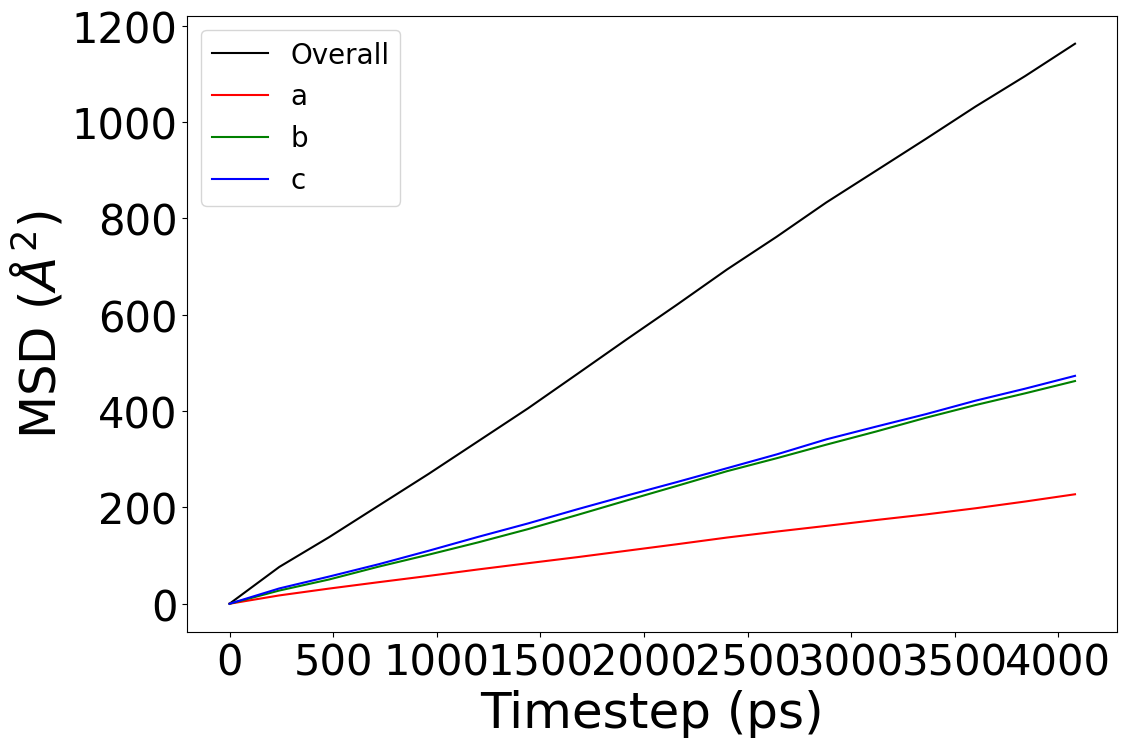

In [13]:
# Plot the smoothed MSD vs. time graph
diff_analyzer.plot_msd(mode="site")  # Default mode plots MSD for all directions combined

In [14]:
diff_analyzer.get_summary_dict(include_msd_t=False, include_mscd_t=False)

{'D': 4.778808319611835e-06,
 'D_sigma': 1.628908921101714e-08,
 'D_charge': 6.196085215792949e-06,
 'D_charge_sigma': 8.690364545833738e-08,
 'S': 161.4804819711737,
 'S_sigma': 0.5504238296965526,
 'S_charge': 209.37161737049541,
 'D_components': [2.71789498764929e-06,
  5.776395008775336e-06,
  5.842134962410875e-06],
 'S_components': [91.8402587422242, 195.18988578070636, 197.4113013905904],
 'D_components_sigma': [1.6636317207706385e-08,
  3.525237638429159e-08,
  2.1484040374430718e-08],
 'S_components_sigma': [0.562156994224026,
  1.1912113540530151,
  0.7259661744777874],
 'specie': 'Mg',
 'step_skip': 100000,
 'time_step': 2.4,
 'temperature': 300,
 'max_framework_displacement': 110.82248148880396,
 'Haven_ratio': 0.7712625235416913}

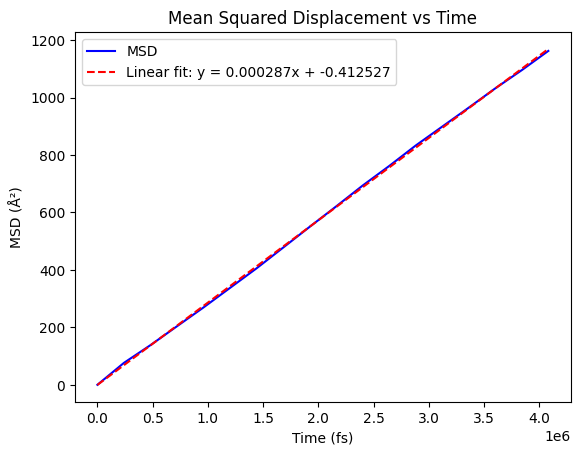

Slope: 2.867285e-04 (Å²/ps)
Diffusivity in Å²/ps: 4.778808e-05
Diffusivity in cm²/s: 4.778808e-06
R-squared value: 0.999814


In [15]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Extract MSD and time data
msd = diff_analyzer.msd  # Mean squared displacement (in Å²)
delta_t = diff_analyzer.dt  # Time intervals (in ps)

# Perform linear regression to find slope
slope, intercept, r_value, p_value, std_err = linregress(delta_t, msd)

# Calculate diffusivity in Å²/ps using the Einstein relation
diffusivity_A2_per_ps = slope / 6  # Diffusivity in Å²/fs

# Convert diffusivity from Å²/ps to cm²/s
# 1 Å² = 1e-16 cm², 1 ps = 1e-12 s, so conversion factor is 1e-4
diffusivity_cm2_per_s = diffusivity_A2_per_ps * 1e-1  # Convert to cm²/s

# Plot MSD and linear fit
plt.plot(delta_t, msd, label="MSD", color="blue")
plt.plot(delta_t, slope * delta_t + intercept, label=f"Linear fit: y = {slope:.6f}x + {intercept:.6f}", color="red", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("MSD (Å²)")
plt.title("Mean Squared Displacement vs Time")
plt.legend()
plt.show()

# Report the results
print(f"Slope: {slope:.6e} (Å²/ps)")
print(f"Diffusivity in Å²/ps: {diffusivity_A2_per_ps:.6e}")
print(f"Diffusivity in cm²/s: {diffusivity_cm2_per_s:.6e}")
print(f"R-squared value: {r_value**2:.6f}")


C:\Users\DEBS\AppData\Local\Temp\ipykernel_38876\2420837355.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


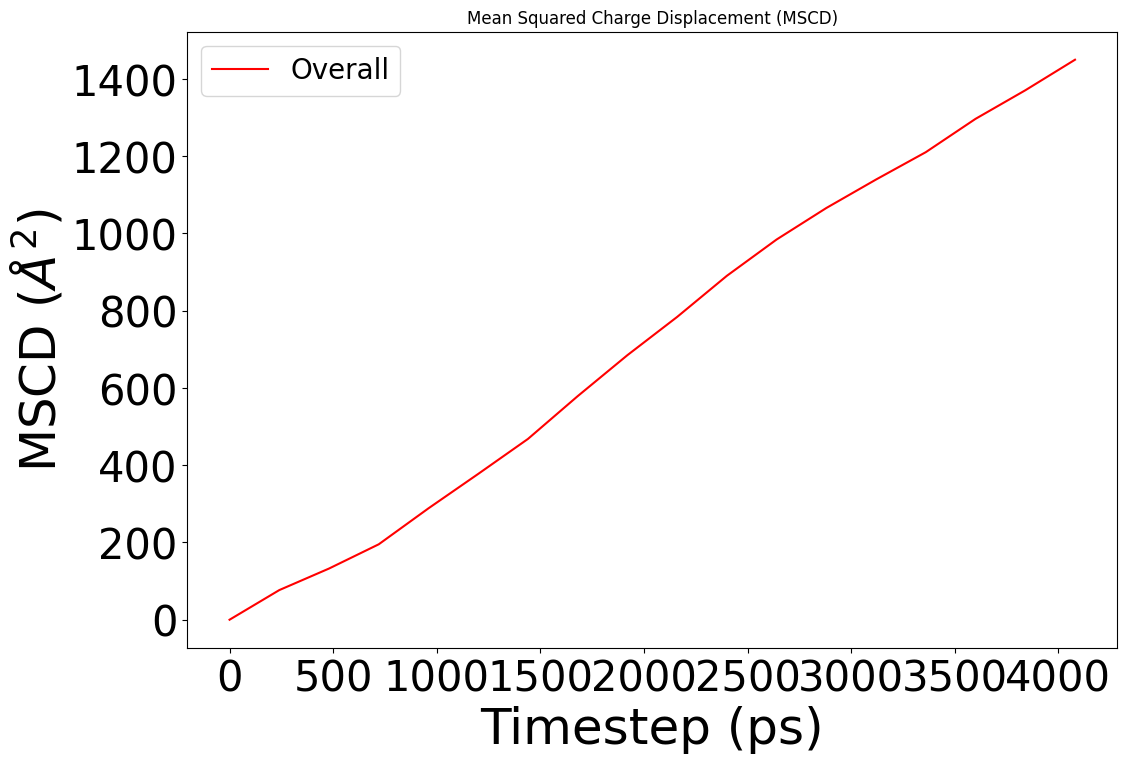

In [16]:
# Plot MSCD
ax = diff_analyzer.get_msd_plot(mode="mscd")
ax.set_title("Mean Squared Charge Displacement (MSCD)")
ax.figure.show()


In [19]:

#diff_calc.plot_msd(mode='default')
diff_analyzer.export_msdt("md_50ps")
import os
import pandas as pd
msd_dft = pd.read_table("md_50ps", delimiter=' ')
print(msd_dft)

            #            t         MSD       MSD_a       MSD_b        MSD_c  \
0         0.0     0.000000    0.000000    0.000000    0.000000     0.000000   
1    240000.0    76.344170   17.252948   27.358703   31.732519    76.706280   
2    480000.0   138.057274   31.421734   50.289611   56.345929   132.500040   
3    720000.0   203.783181   44.736893   77.013708   82.032580   195.288180   
4    960000.0   269.335402   57.717599  101.747352  109.870451   288.424859   
5   1200000.0   337.410822   71.182091  127.401865  138.826867   377.531945   
6   1440000.0   405.534594   84.089610  154.814710  166.630275   468.080148   
7   1680000.0   477.511290   96.760276  184.472838  196.278176   578.834486   
8   1920000.0   549.865077  110.155448  214.850656  224.858974   684.964730   
9   2160000.0   620.985770  123.546885  244.759213  252.679672   783.963607   
10  2400000.0   693.682538  137.358771  275.065898  281.257869   890.435295   
11  2640000.0   761.741515  149.782030  302.012279  

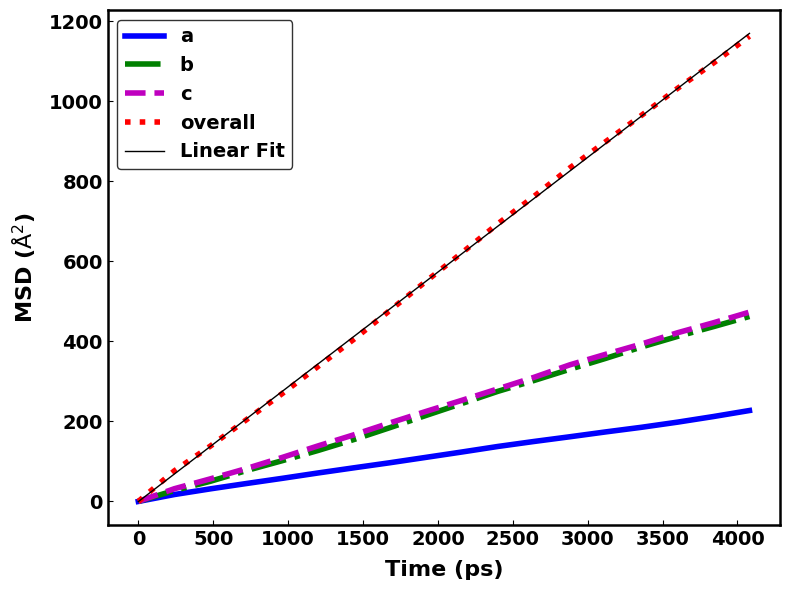

Diffusion Coefficient (Å^2/ps): 0.047788
Diffusion Coefficient (cm^2/s): 4.778808e-06


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load and convert time to ps
time_fs = msd_dft['#']
time = time_fs / 1000

# Use raw MSD data without sampling or cumsum
msd_a = msd_dft['MSD']
msd_b = msd_dft['MSD_a']
msd_c = msd_dft['MSD_b']
msd_t = msd_dft['t']

# Linear regression using raw data
slope, intercept, r_value, p_value, std_err = stats.linregress(time, msd_t)

# Calculate diffusion coefficients
diff_coeff_ang = slope / 6
diff_coeff_cm = diff_coeff_ang * 1e-4

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot raw MSD curves
ax.plot(time, msd_a, linewidth=4, linestyle='-', color='b', label='a')
ax.plot(time, msd_b, linewidth=4, linestyle='dashdot', color='g', label='b')
ax.plot(time, msd_c, linewidth=4, linestyle='--', color='m', label='c')
ax.plot(time, msd_t, linewidth=4, linestyle='dotted', color='r', label='overall')
ax.plot(time, intercept + slope * time, color='k', label='Linear Fit', linewidth=1)

# Set limits and labels

ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Style settings
ax.legend(prop={'weight': 'bold', 'size': 14}, loc="upper left", edgecolor='k')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

plt.tight_layout()
plt.savefig("dd_all_30ps.pdf", format='pdf')
plt.show()

print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")


In [22]:
import pandas as pd
from scipy import stats
import numpy as np

# Load data
msd_dft = pd.read_table("md_50ps", delimiter=' ')

# Check data range first
print(f"Time range in data: {msd_dft['#'].min()} to {msd_dft['#'].max()} fs")

# Adjust split points based on actual data range
max_time = msd_dft['#'].max()
split_point = max_time/2

# Split data
part1 = msd_dft[msd_dft['#'] <= split_point]
part2 = msd_dft[msd_dft['#'] > split_point]

# Verify parts are not empty
print(f"Points in part1: {len(part1)}")
print(f"Points in part2: {len(part2)}")

# Only proceed if both parts have data
if len(part1) > 0 and len(part2) > 0:
    time1 = part1['#']/1000
    time2 = part2['#']/1000
    
    slope1, intercept1, r_value1, _, _ = stats.linregress(time1, part1['t'])
    slope2, intercept2, r_value2, _, _ = stats.linregress(time2, part2['t'])


Time range in data: 0.0 to 4080000.0 fs
Points in part1: 9
Points in part2: 9


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Load data
msd_dft = pd.read_table("md_50ps", delimiter=' ')

# Split data at 2,000,000 fs
part1 = msd_dft[msd_dft['#'] <= 2000000]
part2 = msd_dft[(msd_dft['#'] > 2000000) & (msd_dft['#'] <= 4000000)]

# Convert to ps
time1 = part1['#']/1000
time2 = part2['#']/1000

# Calculate linear regression
slope1, intercept1, r_value1, _, _ = stats.linregress(time1, part1['t'])
slope2, intercept2, r_value2, _, _ = stats.linregress(time2, part2['t'])
r2_score1 = r_value1**2
r2_score2 = r_value2**2

# Calculate diffusion coefficients
D1 = slope1/6
D2 = slope2/6

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot only the fitted lines
ax.plot(time1, intercept1 + slope1*time1, 'b-', 
        label=f'0-2 ns (R² = {r2_score1:.4f})')
ax.plot(time2, intercept2 + slope2*time2, 'r-', 
        label=f'2-4 ns (R² = {r2_score2:.4f})')

# Style plot
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold')
ax.set_ylabel('MSD (Å²)', fontsize=16, fontweight='bold')
ax.legend(prop={'size': 12, 'weight': 'bold'})
plt.tick_params(direction='in', width=1.8)

plt.tight_layout()
plt.savefig('msd_analysis.pdf')
plt.show()

# Print results
print(f"First region (0-2 ns):")
print(f"R² = {r2_score1:.4f}")
print(f"D = {D1:.6f} Å²/ps")
print(f"\nSecond region (2-4 ns):")
print(f"R² = {r2_score2:.4f}")
print(f"D = {D2:.6f} Å²/ps")


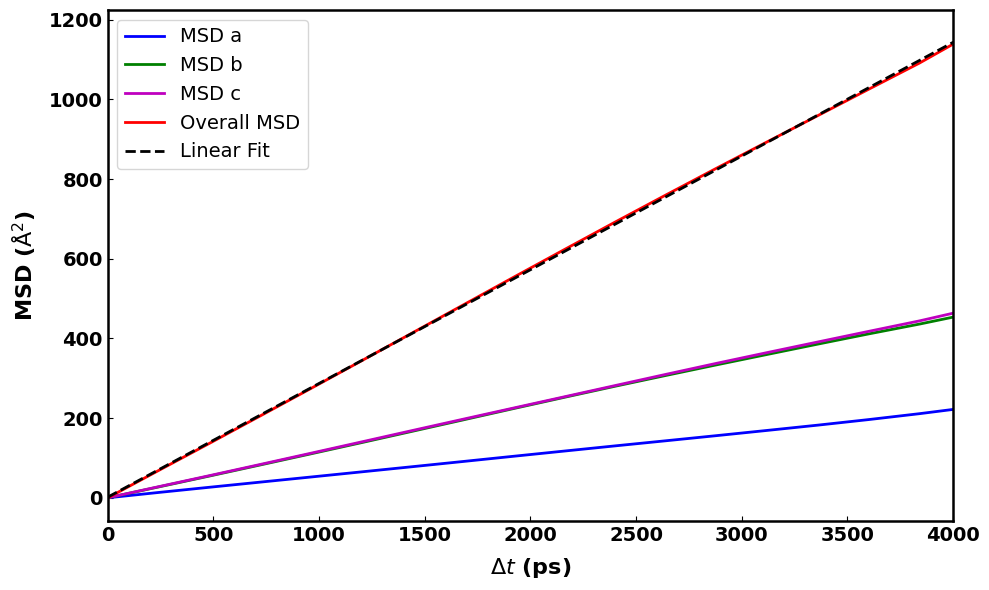

Diffusion Coefficient (Å^2/ps): 0.047559
Diffusion Coefficient (cm^2/s): 4.755946e-06


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# MSD series
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 41040, 240)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with the origin point (0, 0)
MSD_a_averages = [0]  # Start with MSD = 0 at delta_t = 0
MSD_b_averages = [0]
MSD_c_averages = [0]
MSD_t_averages = [0]

# Calculate MSD for each delta_t
for delta_t in delta_t_steps:
    msd_a_values = []  # To store MSD for each interval in msd_a
    msd_b_values = []  # To store MSD for each interval in msd_b
    msd_c_values = []  # To store MSD for each interval in msd_c
    msd_t_values = []  # To store MSD for each interval in msd_t

    # Loop through valid time windows based on delta_t
    for start_idx in range(len(msd_a) - delta_t // 240):  # 200 ps corresponds to a step size of 1 in your data
        end_idx = start_idx + delta_t // 240  # Calculate the index for delta_t

        # Ensure the indices are valid
        if end_idx < len(msd_a):
            # Calculate MSD for each series
            msd_a_values.append(msd_a.iloc[end_idx] - msd_a.iloc[start_idx])
            msd_b_values.append(msd_b.iloc[end_idx] - msd_b.iloc[start_idx])
            msd_c_values.append(msd_c.iloc[end_idx] - msd_c.iloc[start_idx])
            msd_t_values.append(msd_t.iloc[end_idx] - msd_t.iloc[start_idx])

    # Calculate the average MSD for this delta_t if valid values are found
    if msd_a_values:
        MSD_a_averages.append(np.mean(msd_a_values))
        MSD_b_averages.append(np.mean(msd_b_values))
        MSD_c_averages.append(np.mean(msd_c_values))
        MSD_t_averages.append(np.mean(msd_t_values))
        delta_t_values.append(delta_t)

# Plot MSD vs Delta t
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MSD data with continuous lines (no markers)
ax.plot(delta_t_values, MSD_a_averages, '-', label='MSD a', linewidth=2, color='b')
ax.plot(delta_t_values, MSD_b_averages, '-', label='MSD b', linewidth=2, color='g')
ax.plot(delta_t_values, MSD_c_averages, '-', label='MSD c', linewidth=2, color='m')
ax.plot(delta_t_values, MSD_t_averages, '-', label='Overall MSD', linewidth=2, color='r')

# Add a linear regression line for the overall MSD
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_t_averages)
r_squared = r_value**2
ax.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit', color='black', linewidth=2)

# Axis labels and legend
ax.set_xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(loc="upper left", fontsize=14)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')
plt.xlim(0, 4000)
# Show the plot
plt.tight_layout()

# Save the figure as PDF
plt.savefig("msd_vs_delta_t_all_series_300_continuous.pdf", format='pdf')
plt.savefig("msd_vs_delta_t_all_series_300_continuous.tif", format='tif')

# Display the plot
plt.show()

# Print the calculated diffusivity
print(f"Diffusion Coefficient (Å^2/ps): {slope / 6:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {slope / 6 * 1e-4:.6e}")


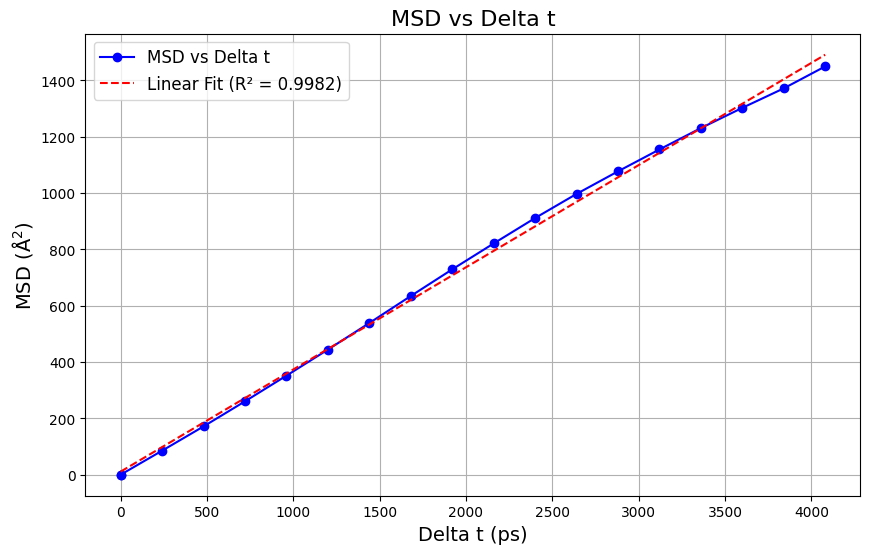

Slope: 0.362867
Intercept: 10.948458
R² Score: 0.998236
Delta t = 0 ps, Average MSD = 0.000000
Delta t = 0 ps, Average MSD = 0.000000
Delta t = 240 ps, Average MSD = 85.286761
Delta t = 480 ps, Average MSD = 171.491575
Delta t = 720 ps, Average MSD = 260.543935
Delta t = 960 ps, Average MSD = 351.672182
Delta t = 1200 ps, Average MSD = 444.209132
Delta t = 1440 ps, Average MSD = 538.597621
Delta t = 1680 ps, Average MSD = 634.499884
Delta t = 1920 ps, Average MSD = 729.109953
Delta t = 2160 ps, Average MSD = 821.122045
Delta t = 2400 ps, Average MSD = 911.387441
Delta t = 2640 ps, Average MSD = 997.071246
Delta t = 2880 ps, Average MSD = 1077.195242
Delta t = 3120 ps, Average MSD = 1154.943744
Delta t = 3360 ps, Average MSD = 1230.852636
Delta t = 3600 ps, Average MSD = 1302.719674
Delta t = 3840 ps, Average MSD = 1371.932604
Delta t = 4080 ps, Average MSD = 1449.874934


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is your DataFrame
time_ps = msd_md['#'] / 1000  # Convert time to picoseconds
MSCD = msd_md['MSD_c']  # MSCD values

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 41040, 240)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with delta_t = 0
MSD_averages = [0]  # Start with MSD = 0 at delta_t = 0

# Loop over each delta_t value (200, 400, 600, ..., 4000)
for delta_t in delta_t_steps:
    msd_values = []  # To store MSD for each interval at delta_t
    
    # Loop over the valid time windows for each delta_t
    for start_idx in range(0, len(MSCD) - delta_t // 240):
        end_idx = start_idx + delta_t // 240
        
        if end_idx < len(MSCD):  # Ensure valid indices
            msd = MSCD.iloc[end_idx] - MSCD.iloc[start_idx]  # Calculate MSCD for this interval
            msd_values.append(msd)
    
    # Calculate the average MSD for this delta_t if valid values exist
    if msd_values:
        avg_msd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSD_averages.append(avg_msd)

# Linear regression and R² calculation
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_averages)
r_squared = r_value**2

# Now, plotting the results
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, MSD_averages, 'o-', label='MSD vs Delta t', color='blue')

# Plot the linear fit
plt.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit (R² = {r_squared:.4f})', color='red')

# Labeling the plot
plt.xlabel('Delta t (ps)', fontsize=14)
plt.ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=14)
plt.title('MSD vs Delta t', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
#plt.xlim(0, 4000)

# Show the plot
plt.show()

# Print the regression results
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R² Score: {r_squared:.6f}")

# Print the average MSD values for each delta_t
for delta_t, avg_msd in zip(delta_t_values, MSD_averages):
    print(f"Delta t = {delta_t} ps, Average MSD = {avg_msd:.6f}")


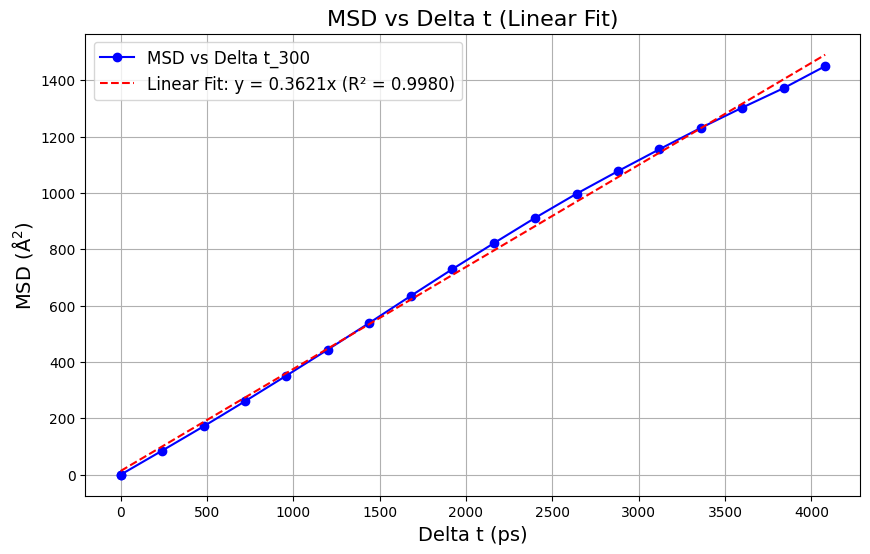

Slope (m): 0.362067
Intercept: 13.189371
R² Score: 0.998018
Results have been saved to 'msd_vs_delta_t.xlsx'.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is your DataFrame
time_ps = msd_md['#'] / 1000  # Convert time to picoseconds
MSCD = msd_md['MSD_c']  # MSCD values

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 41040, 240)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with delta_t = 0
MSD_averages = [0]  # Start with MSD = 0 at delta_t = 0

# Loop over each delta_t value (200, 400, 600, ..., 4000)
for delta_t in delta_t_steps:
    msd_values = []  # To store MSD for each interval at delta_t
    
    # Loop over the valid time windows for each delta_t
    for start_idx in range(0, len(MSCD) - delta_t // 240):
        end_idx = start_idx + delta_t // 240
        
        if end_idx < len(MSCD):  # Ensure valid indices
            msd = MSCD.iloc[end_idx] - MSCD.iloc[start_idx]  # Calculate MSCD for this interval
            msd_values.append(msd)
    
    # Calculate the average MSD for this delta_t if valid values exist
    if msd_values:
        avg_msd = np.mean(msd_values)
        delta_t_values.append(delta_t)
        MSD_averages.append(avg_msd)

# Perform linear regression to find the slope (m) and intercept
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values[1:], MSD_averages[1:])

# R² score (coefficient of determination)
r_squared = r_value**2

# Now, plotting the results
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, MSD_averages, 'o-', label='MSD vs Delta t_300', color='blue')

# Plot the linear fit (y = mx)
plt.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit: y = {slope:.4f}x (R² = {r_squared:.4f})', color='red')

# Labeling the plot
plt.xlabel('Delta t (ps)', fontsize=14)
plt.ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=14)
plt.title('MSD vs Delta t (Linear Fit)', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# Print the slope (m), intercept, and R² score
print(f"Slope (m): {slope:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R² Score: {r_squared:.6f}")

# Save the MSCD and delta_t values in an Excel file
result_df = pd.DataFrame({
    'Time (ps)': delta_t_values[1:],  # Skip the first entry (0 ps)
    'MSD (Å²)': MSD_averages[1:]  # Skip the first entry (MSD = 0)
})

# Save the DataFrame to an Excel file
result_df.to_excel('msd_vs_delta_t_900.xlsx', index=False)

print("Results have been saved to 'msd_vs_delta_t.xlsx'.")


Slope: 0.362067 Å²/ps
Final Result: 6.034451e-06 cm²/s


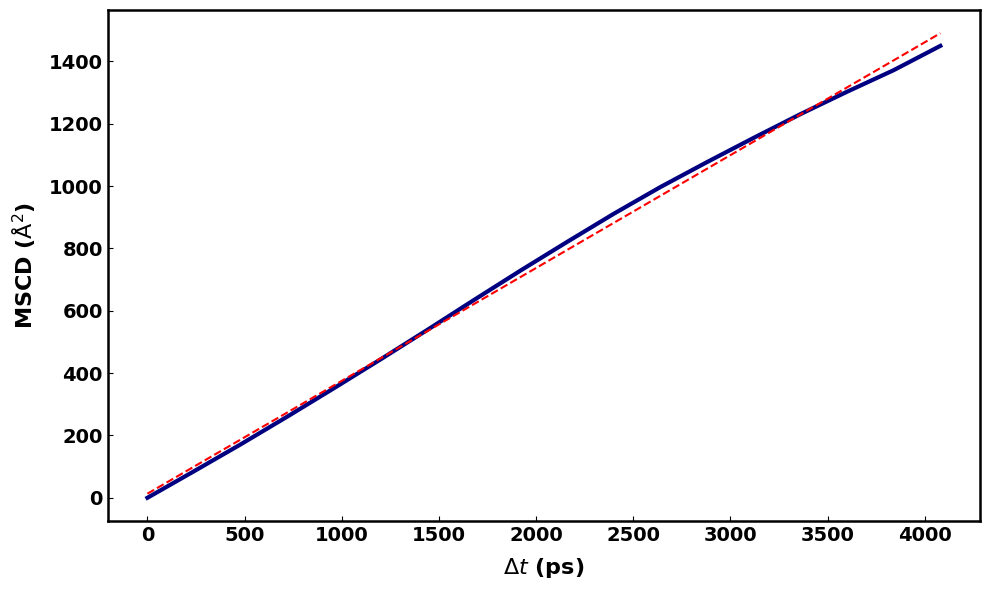

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data from the Excel file
df_mscd = pd.read_excel("msd_vs_delta_t_900.xlsx")

# Extract the data using the correct column names
time_ps = df_mscd['Time (ps)']
MSD_values = df_mscd['MSD (Å²)']

# Perform linear regression to calculate the slope
slope, intercept, r_value, p_value, std_err = linregress(time_ps, MSD_values)

# Perform the requested operations
result = (slope / 6) * 1e-4

# Print the slope and the final result
print(f"Slope: {slope:.6f} Å²/ps")
print(f"Final Result: {result:.6e} cm²/s")

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(time_ps, MSD_values, '-', color=(0, 0, 0.5), linewidth=3)  # Deep navy blue, thicker line
plt.plot(time_ps, intercept + slope * time_ps, '--', color='red', label=f'Linear Fit: Slope = {slope:.4f}')  # Linear fit line
plt.xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
plt.ylabel('MSCD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Set x-axis and y-axis limits
#plt.xlim(0, 4000)
#plt.ylim(0, 800)

# Save the plot as PDF
plt.tight_layout()
#plt.legend(fontsize=12)
plt.savefig("dd_mscd_30ps_with_fit.pdf", format='pdf')

# Display the plot
plt.show()


In [1]:
4.755946e-06/ 6.034451e-06 

0.7881323421136405